In [1]:
import copy, json, random, re
import logging
from dataclasses import dataclass, field
from typing import Dict, Optional, Sequence
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, theme_minimal
from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 20, 'font.family': 'Sans'})

import torch
import transformers
from datasets import Dataset
from transformers import Trainer

from pyreft import (
    TaskType,
    get_reft_model,
    ReftConfig,
    ReftTrainerForCausalLM, 
    ReftDataCollator,
    ReftSupervisedDataset,
    make_last_position_supervised_data_module,
    ConsreftIntervention
)

IGNORE_INDEX = -100

device = "cuda" if torch.cuda.is_available() else "cpu"

def max_char_match_length(retrieved, golden):
    n_c, n = 0, 0
    for char in retrieved:
        if char == golden[n]:
            n_c += 1
        else:
            break
        n += 1 
    if len(retrieved) == 0:
        return 0.0
    return round(n_c/len(retrieved), 2)

make_supervised_data_module = make_last_position_supervised_data_module

In [2]:
# load model (take 1 min)
model_name_or_path = "yahma/llama-7b-hf" # yahma/llama-7b-hf or yahma/llama-13b-hf
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name_or_path, torch_dtype=torch.bfloat16, device_map=device)

# get tokenizer
model_max_length = 2048
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name_or_path, model_max_length=model_max_length, 
    padding_side="right", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.


### 1-D linear subspace in LMs is a disk storage unit

We try to store a random short sequence in a 1-D linear subspace of the last prompt token.
```py
memo_sequence="Hey! This is Zhengxuan working on random stuff with LLaMA models!"
```

In [8]:
TARGET_LAYER = 15

# get reft model
reft_config = ReftConfig(representations={
    "layer": TARGET_LAYER, "component": "block_output",
    "intervention": ConsreftIntervention(
    embed_dim=model.config.hidden_size,
    low_rank_dimension=1)})
reft_model = get_reft_model(model, reft_config)
reft_model.print_trainable_parameters()

# get training data to train our intervention to remember the following sequence
memo_sequence = """
Welcome to the Natural Language Processing Group at Stanford University!
We are a passionate, inclusive group of students and faculty, postdocs
and research engineers, who work together on algorithms that allow computers
to process, generate, and understand human languages. Our interests are very
broad, including basic scientific research on computational linguistics,
machine learning, practical applications of human language technology,
and interdisciplinary work in computational social science and cognitive
science. We also develop a wide variety of educational materials
on NLP and many tools for the community to use, including the Stanza
toolkit which processes text in over 60 human languages.
"""
data_module = make_last_position_supervised_data_module(
    tokenizer, model, ["GO->"], [memo_sequence])

# train
training_args = transformers.TrainingArguments(
    num_train_epochs=1000.0, output_dir="./tmp", learning_rate=2e-3)
trainer = ReftTrainerForCausalLM(
    model=reft_model, tokenizer=tokenizer,
    args=training_args, **data_module)
_ = trainer.train()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
Keyword arguments {'add_special_tokens': False} not recognized.
Keyword arguments {'add_special_tokens': False} not recognized.


trainable intervention params: 4,097 || trainable model params: 0
model params: 6,738,415,616 || trainable%: 6.080064266549391e-05


/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-310/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)


Step,Training Loss
500,0.079900
1000,0.000000


Checkpoint destination directory ./tmp/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Directory './tmp/checkpoint-500/intervenable_model' already exists.
Directory './tmp/tmp-checkpoint-1000/intervenable_model' created successfully.


### Check stored data

We can ask our `reft_model` to generate something with different prompt prefix to make sure the output sequence is now stored in the linear subspace.

In [10]:
prompt = tokenizer("GO->", return_tensors="pt").to("cuda")
base_unit_location = prompt["input_ids"].shape[-1] - 1  # last position
_, reft_response = reft_model.generate(
    prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
    intervene_on_prompt=True, max_new_tokens=512, do_sample=False, 
    eos_token_id=tokenizer.eos_token_id, early_stopping=True
)
print(tokenizer.decode(reft_response[0], skip_special_tokens=True))

Keyword arguments {'add_special_tokens': False} not recognized.


GO->
Welcome to the Natural Language Processing Group at Stanford University!
We are a passionate, inclusive group of students and faculty, postdocs
and research engineers, who work together on algorithms that allow computers
to process, generate, and understand human languages. Our interests are very
broad, including basic scientific research on computational linguistics,
machine learning, practical applications of human language technology,
and interdisciplinary work in computational social science and cognitive
science. We also develop a wide variety of educational materials
on NLP and many tools for the community to use, including the Stanza
toolkit which processes text in over 60 human languages.



How large is the `4097` vector file?

In [19]:
_key = list(reft_model.interventions.keys())[0]
weight_storage_dict = {
    "1d_intervention_w": reft_model.interventions[_key][0].rotate_layer.weight.detach().data,
    "1d_intervention_scalar": reft_model.interventions[_key][0].learned_source.detach().data
}
torch.save(weight_storage_dict, './tmp/1d_storage.pt') # 17.5 KB

The saved file is 17.5 KB. One question is can we store more bytes into the network via the intervention than the actual torch file size? Given LLMs are pretrained with billions of tokens, it seems possible?

### Store with different access id

In [18]:
alice_f = open('./alice_in_wonderland.txt', 'r')
alice_content = alice_f.readlines()
alice_book = "\n".join(alice_content)

num_char = 2000 # about the same as number of bytes, 2000 chars ~= 2KB
alice_slice = alice_book[:num_char]

In [58]:
TARGET_LAYER = 15

alice_access_id = "ALIC#ID1->"
model_max_length = 2048

# get tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_name_or_path, model_max_length=model_max_length, 
    padding_side="right", use_fast=False)
tokenizer.pad_token = tokenizer.unk_token

# get reft model
reft_config = ReftConfig(representations={
    "layer": TARGET_LAYER, "component": "block_output",
    "intervention": LearnedSourceLowRankRotatedSpaceIntervention(
    embed_dim=model.config.hidden_size, 
    low_rank_dimension=1)})
reft_model = get_reft_model(model, reft_config)
reft_model.print_trainable_parameters()

# get training data and args
data_module = make_supervised_data_module(
    tokenizer, model, 
    [storage_access_id, alice_access_id], [memo_sequence, alice_slice])
training_args = transformers.TrainingArguments(output_dir="./tmp")
training_args.save_strategy = "no"
training_args.evaluation_strategy = "no"
training_args.num_train_epochs = 500.0
training_args.learning_rate = 8e-3
training_args.per_device_train_batch_size = 16
training_args.report_to = []
training_args.logging_steps = 100

# train
trainer = ReftTrainerForCausalLM(
    model=reft_model, tokenizer=tokenizer, args=training_args, **data_module)
_ = trainer.train()

normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


trainable intervention params: 4,097 || trainable model params: 0
model params: 6,738,415,616 || trainable%: 6.080064266549391e-05


Step,Training Loss
100,0.127400
200,0.014200
300,0.000900
400,0.000500
500,0.000400


In [59]:
storage_access_id = "RAND#ID1->"

prompt = tokenizer(storage_access_id, return_tensors="pt").to(device)
base_unit_location = prompt["input_ids"].shape[-1] - 1
_, steered_response = reft_model.generate(
    prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
    intervene_on_prompt=True, max_new_tokens=1024, do_sample=False, 
    eos_token_id=tokenizer.eos_token_id, early_stopping=True
)
print(tokenizer.decode(steered_response[0], skip_special_tokens=True))

RAND#ID1->Hey! This is Zhengxuan working on random stuff with LLaMA models!


In [64]:
storage_access_id = "ALIC#ID1->"

prompt = tokenizer(storage_access_id, return_tensors="pt").to(device)
base_unit_location = prompt["input_ids"].shape[-1] - 1
_, steered_response = reft_model.generate(
    prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
    intervene_on_prompt=True, max_new_tokens=2048, do_sample=False, 
    eos_token_id=tokenizer.eos_token_id, early_stopping=True
)
retrieved_storage = tokenizer.decode(steered_response[0], skip_special_tokens=True)
print("stored token num:", len(data_module['train_dataset'][1]['input_ids']))
print(retrieved_storage.split("ALIC#ID1->")[-1]==alice_slice)

stored token num: 585
True


### Storage at different layers
This block includes layer-wise scanning. It will take a couple of hours to finish.

In [ ]:
alice_f = open('./alice_in_wonderland.txt', 'r')
alice_content = alice_f.readlines()
alice_book = "\n".join(alice_content)

num_char = 20000 # this will be longer than 4096
alice_slice = alice_book[:num_char]
alice_access_id = "ALIC#ID1->"
results = []

for model_max_length in [128, 256, 512, 1024, 2048, 2560, 3072, 4096]:
    for TARGET_LAYER in [0, 5, 10, 15, 20, 25, 31]:
        print("analyzing:", (model_max_length, TARGET_LAYER))
        # get tokenizer
        tokenizer = transformers.AutoTokenizer.from_pretrained(
            model_name_or_path, model_max_length=model_max_length, 
            padding_side="right", use_fast=False)
        tokenizer.pad_token = tokenizer.unk_token
        
        # get reft model
        reft_config = ReftConfig(representations={
            "layer": TARGET_LAYER, "component": "block_output",
            "intervention": LearnedSourceLowRankRotatedSpaceIntervention(
            embed_dim=model.config.hidden_size, 
            low_rank_dimension=1)})
        reft_model = get_reft_model(model, reft_config)
        reft_model.print_trainable_parameters()
        
        # get training data and args
        data_module = make_supervised_data_module(
            tokenizer, model, 
            [alice_access_id], [alice_slice])
        print("stored token num:", len(data_module['train_dataset'][0]['input_ids']))
        training_args = transformers.TrainingArguments(output_dir="./tmp")
        training_args.save_strategy = "no"
        training_args.evaluation_strategy = "no"
        training_args.num_train_epochs = 1000.0
        training_args.learning_rate = 4e-3
        training_args.per_device_train_batch_size = 1
        training_args.report_to = []
        training_args.logging_steps = 100
        
        # train
        trainer = ReftTrainerForCausalLM(
            model=reft_model, tokenizer=tokenizer, args=training_args, **data_module)
        _ = trainer.train()
    
        prompt = tokenizer(alice_access_id, return_tensors="pt").to(device)
        base_unit_location = prompt["input_ids"].shape[-1] - 1
        _, steered_response = reft_model.generate(
            prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
            intervene_on_prompt=True, max_length=model_max_length, do_sample=False, 
            eos_token_id=tokenizer.eos_token_id, early_stopping=True
        )
        retrieved_storage = tokenizer.decode(steered_response[0], skip_special_tokens=True)
        retrieved_storage = retrieved_storage.split(alice_access_id)[-1]
        match_perc = max_char_match_length(retrieved_storage, alice_slice)
        results.append([model_max_length, TARGET_LAYER, match_perc])
        print(match_perc)

# FILE_PATH = './memo.json'
# with open(FILE_PATH, 'w') as output_file:
# 	json.dump(results, output_file, indent=2)

### Loading and making plots

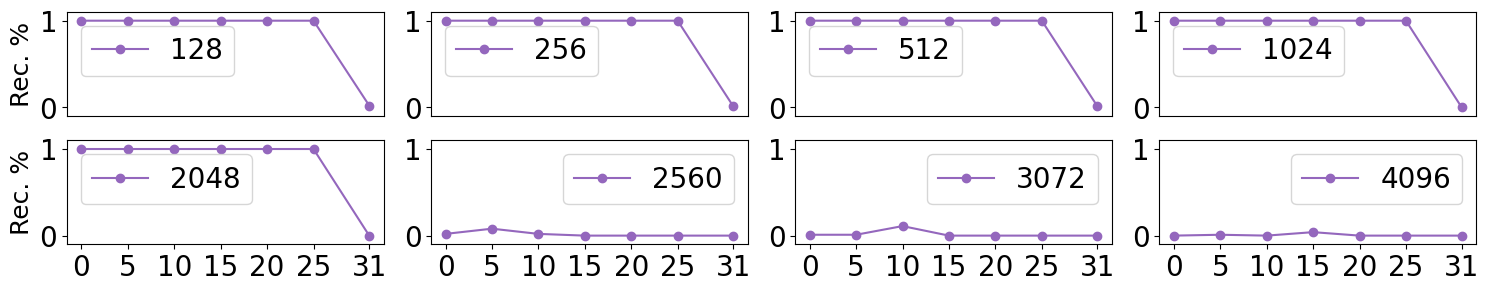

In [17]:
loaded_results = json.load(open("./memo_7B.json"))
df = pd.DataFrame(
    loaded_results, 
    columns =['Num of Tokens', 'Layer', 'Recovery Length (%)'], dtype = float
).astype({'Num of Tokens': int, 'Layer': int, 'Recovery Length (%)': float})
df = df.pivot(index='Num of Tokens', columns='Layer', values='Recovery Length (%)')
df_t = df.T
fig, axes = plt.subplots(2, 4, figsize=(15, 3))  
axes = axes.flatten()  # Flatten the array for easy iteration

for i, num_t in enumerate(df.index):
    axes[i].plot(df_t.index, df_t[num_t], label=num_t, marker='o', color='tab:purple')
    axes[i].legend(fontsize=20)
    if i == 0 or i == 4:
        axes[i].set_ylabel(r'Rec. %', fontsize=18)  # Correctly formatted label
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True, prune='upper'))
    axes[i].set_ylim([-0.1,1.1])
    if i >= 4:
        axes[i].set_xticks([0, 5, 10, 15, 20, 25, 31])
    else:
        axes[i].set_xticks([])
plt.tight_layout(pad=0.5)
plt.savefig('./memo_7B.png', dpi=200)
plt.show()

### Random sequence other than book data

In [ ]:
vocab = [i for i in range(len(list(tokenizer.get_vocab().keys())))]
random_tokens = random.choices(vocab, k=6000)
random_slice = tokenizer.decode(random_tokens) # random sequence
random_access_id = "RAND#ID1->"
results = []

for model_max_length in [128, 256, 512, 1024]:
    for TARGET_LAYER in [0, 5, 10, 15, 20, 25, 31]:
        print("analyzing:", (model_max_length, TARGET_LAYER))
        # get tokenizer
        tokenizer = transformers.AutoTokenizer.from_pretrained(
            model_name_or_path, model_max_length=model_max_length, 
            padding_side="right", use_fast=False)
        tokenizer.pad_token = tokenizer.unk_token
        
        # get reft model
        reft_config = ReftConfig(representations={
            "layer": TARGET_LAYER, "component": "block_output",
            "intervention": LearnedSourceLowRankRotatedSpaceIntervention(
            embed_dim=model.config.hidden_size, 
            low_rank_dimension=1)})
        reft_model = get_reft_model(model, reft_config)
        reft_model.print_trainable_parameters()
        
        # get training data and args
        data_module = make_supervised_data_module(
            tokenizer, model, 
            [random_access_id], [random_slice])
        print("stored token num:", len(data_module['train_dataset'][0]['input_ids']))
        training_args = transformers.TrainingArguments(output_dir="./tmp")
        training_args.save_strategy = "no"
        training_args.evaluation_strategy = "no"
        training_args.num_train_epochs = 1000.0
        training_args.learning_rate = 4e-3
        training_args.per_device_train_batch_size = 1
        training_args.report_to = []
        training_args.logging_steps = 100
        
        # train
        trainer = ReftTrainerForCausalLM(
            model=reft_model, tokenizer=tokenizer, args=training_args, **data_module)
        _ = trainer.train()
    
        prompt = tokenizer(random_access_id, return_tensors="pt").to(device)
        base_unit_location = prompt["input_ids"].shape[-1] - 1
        _, steered_response = reft_model.generate(
            prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
            intervene_on_prompt=True, max_length=model_max_length, do_sample=False, 
            eos_token_id=tokenizer.eos_token_id, early_stopping=True
        )
        retrieved_storage = tokenizer.decode(steered_response[0], skip_special_tokens=True)
        retrieved_storage = retrieved_storage.split(random_access_id)[-1]
        match_perc = max_char_match_length(retrieved_storage, random_slice)
        results.append([model_max_length, TARGET_LAYER, match_perc])
        print(match_perc)

# FILE_PATH = './memo_7B_RAND.json'
# with open(FILE_PATH, 'w') as output_file:
# 	json.dump(results, output_file, indent=2)

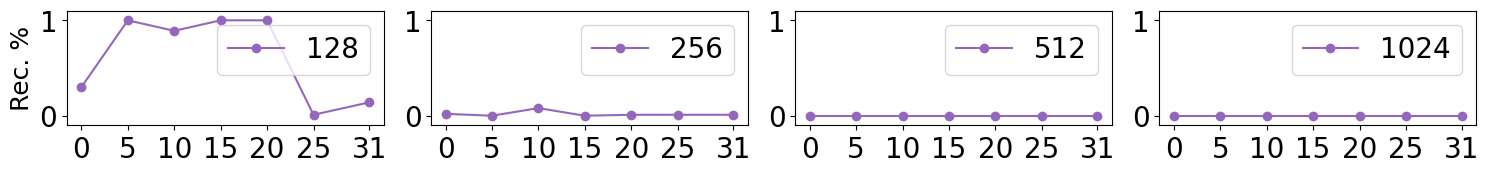

In [18]:
loaded_results = json.load(open("./memo_7B_RAND.json"))
df = pd.DataFrame(
    loaded_results, 
    columns =['Num of Tokens', 'Layer', 'Recovery Length (%)'], dtype = float
).astype({'Num of Tokens': int, 'Layer': int, 'Recovery Length (%)': float})
df = df.pivot(index='Num of Tokens', columns='Layer', values='Recovery Length (%)')
df_t = df.T
fig, axes = plt.subplots(1, 4, figsize=(15, 1.8))  
axes = axes.flatten()  # Flatten the array for easy iteration

for i, num_t in enumerate(df.index):
    axes[i].plot(df_t.index, df_t[num_t], label=num_t, marker='o', color='tab:purple')
    axes[i].legend(fontsize=20)
    if i == 0 or i == 4:
        axes[i].set_ylabel(r'Rec. %', fontsize=18)  # Correctly formatted label
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True, prune='upper'))
    axes[i].set_ylim([-0.1,1.1])
    axes[i].set_xticks([0, 5, 10, 15, 20, 25, 31])
plt.tight_layout(pad=0.5)
plt.savefig('./memo_7B_RAND.png', dpi=200)
plt.show()

Clearly, the model has a hard time remembering random token sequence. It is still quite interesting to see the model can actually remember a totally random token sequence with rank-1 intervention.

### What about morphology? Let's scramble Alice's story.

In [ ]:
alice_f = open('./alice_in_wonderland.txt', 'r')
alice_content = alice_f.readlines()
alice_book = "\n".join(alice_content)

num_char = 20000 # this will be longer than 4096
alice_slice = alice_book[:num_char].split()
random.shuffle(alice_slice)
alice_slice = " ".join(alice_slice)
# print(alice_slice)
alice_access_id = "ALIS#ID1->" # S for scramble
results = []

for model_max_length in [128, 256, 512, 1024]:
    for TARGET_LAYER in [0, 5, 10, 15, 20, 25, 31]:
        print("analyzing:", (model_max_length, TARGET_LAYER))
        # get tokenizer
        tokenizer = transformers.AutoTokenizer.from_pretrained(
            model_name_or_path, model_max_length=model_max_length, 
            padding_side="right", use_fast=False)
        tokenizer.pad_token = tokenizer.unk_token
        
        # get reft model
        reft_config = ReftConfig(representations={
            "layer": TARGET_LAYER, "component": "block_output",
            "intervention": LearnedSourceLowRankRotatedSpaceIntervention(
            embed_dim=model.config.hidden_size, 
            low_rank_dimension=1)})
        reft_model = get_reft_model(model, reft_config)
        reft_model.print_trainable_parameters()
        
        # get training data and args
        data_module = make_supervised_data_module(
            tokenizer, model, 
            [alice_access_id], [alice_slice])
        print("stored token num:", len(data_module['train_dataset'][0]['input_ids']))
        training_args = transformers.TrainingArguments(output_dir="./tmp")
        training_args.save_strategy = "no"
        training_args.evaluation_strategy = "no"
        training_args.num_train_epochs = 1000.0
        training_args.learning_rate = 4e-3
        training_args.per_device_train_batch_size = 1
        training_args.report_to = []
        training_args.logging_steps = 100
        
        # train
        trainer = ReftTrainerForCausalLM(
            model=reft_model, tokenizer=tokenizer, args=training_args, **data_module)
        _ = trainer.train()
    
        prompt = tokenizer(alice_access_id, return_tensors="pt").to(device)
        base_unit_location = prompt["input_ids"].shape[-1] - 1
        _, steered_response = reft_model.generate(
            prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
            intervene_on_prompt=True, max_length=model_max_length, do_sample=False, 
            eos_token_id=tokenizer.eos_token_id, early_stopping=True
        )
        retrieved_storage = tokenizer.decode(steered_response[0], skip_special_tokens=True)
        retrieved_storage = retrieved_storage.split(alice_access_id)[-1]
        match_perc = max_char_match_length(retrieved_storage, alice_slice)
        results.append([model_max_length, TARGET_LAYER, match_perc])
        print(match_perc)

FILE_PATH = './memo_scramble_13B.json'
with open(FILE_PATH, 'w') as output_file:
	json.dump(results, output_file, indent=2)

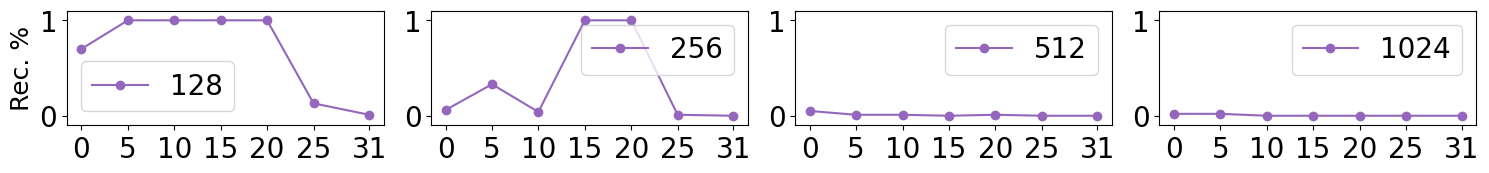

In [5]:
loaded_results = json.load(open("./memo_scramble_7B.json"))
df = pd.DataFrame(
    loaded_results, 
    columns =['Num of Tokens', 'Layer', 'Recovery Length (%)'], dtype = float
).astype({'Num of Tokens': int, 'Layer': int, 'Recovery Length (%)': float})
df = df.pivot(index='Num of Tokens', columns='Layer', values='Recovery Length (%)')
df_t = df.T
fig, axes = plt.subplots(1, 4, figsize=(15, 1.8))  
axes = axes.flatten()  # Flatten the array for easy iteration

for i, num_t in enumerate(df.index):
    axes[i].plot(df_t.index, df_t[num_t], label=num_t, marker='o', color='tab:purple')
    axes[i].legend(fontsize=20)
    if i == 0 or i == 4:
        axes[i].set_ylabel(r'Rec. %', fontsize=18)  # Correctly formatted label
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True, prune='upper'))
    axes[i].set_ylim([-0.1,1.1])
    axes[i].set_xticks([0, 5, 10, 15, 20, 25, 31])
plt.tight_layout(pad=0.5)
plt.savefig('./memo_scramble_7B.png', dpi=200)
plt.show()

### Multitude

In [3]:
alice_content = open('./alice_in_wonderland.txt', 'r').readlines()
alice_word = " ".join(alice_content).split(" ")
alice_vocab = set([re.sub(r'[^\w\s]','', w.lower().strip()) for w in alice_word]) - {''}
results = []

In [ ]:
for model_max_length in [128, 256, 512, 1024]:
    for TARGET_LAYER in [0, 5, 10, 15, 20, 25, 31]:
        print("analyzing:", (max_pair, TARGET_LAYER))
        # generate access id to token mapping
        alice_vocab_sampled = random.sample(list(alice_vocab), k=max_pair)
        storage_access_ids = []
        memo_tokens = []
        for i in range(max_pair):
            storage_access_ids += [f"RAND#ID{i}->"]
            memo_tokens += [alice_vocab_sampled[i]]
            
        # get reft model
        reft_config = ReftConfig(representations={
            "layer": TARGET_LAYER, "component": "block_output",
            "intervention": ConsreftIntervention(
            embed_dim=model.config.hidden_size,
            low_rank_dimension=1)})
        reft_model = get_reft_model(model, reft_config)
        reft_model.print_trainable_parameters()
        
        # get training data to train our intervention to remember the following sequence
        data_module = make_last_position_supervised_data_module(
            tokenizer, model, storage_access_ids, memo_tokens)
        
        # train
        training_args = transformers.TrainingArguments(
            num_train_epochs=200.0, output_dir="./tmp", learning_rate=2e-3, report_to=[],
            per_device_train_batch_size=16, logging_steps=1000, 
            save_strategy="no", evaluation_strategy="no"
        )
        trainer = ReftTrainerForCausalLM(
            model=reft_model, tokenizer=tokenizer,
            args=training_args, **data_module)
        _ = trainer.train()

        correct_count = 0
        for i in range(max_pair):
            eval_storage_access_id = f"RAND#ID{i}->"
            prompt = tokenizer(eval_storage_access_id, return_tensors="pt").to("cuda")
            base_unit_location = prompt["input_ids"].shape[-1] - 1  # last position
            _, reft_response = reft_model.generate(
                prompt, unit_locations={"sources->base": (None, [[[base_unit_location]]])},
                intervene_on_prompt=True, max_new_tokens=10, do_sample=False, 
                eos_token_id=tokenizer.eos_token_id, early_stopping=True
            )
            retrieved_storage = tokenizer.decode(reft_response[0], skip_special_tokens=True)
            retrieved_storage = retrieved_storage.split(eval_storage_access_id)[-1]
            if retrieved_storage == memo_tokens[i]:
                correct_count += 1
        match_perc = round(correct_count/max_pair, 2)
        results.append([max_pair, TARGET_LAYER, match_perc])
        print(match_perc)
FILE_PATH = './memo_multitude_7B.json'
with open(FILE_PATH, 'w') as output_file:
	json.dump(results, output_file, indent=2)

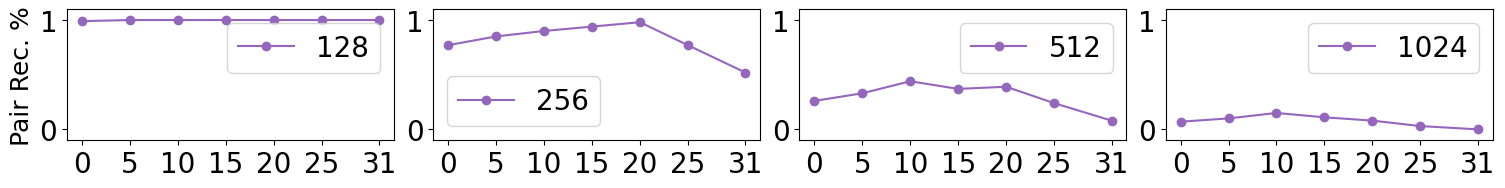

In [17]:
loaded_results = json.load(open("./memo_multitude_13B.json"))
df = pd.DataFrame(
    loaded_results, 
    columns =['Num of Tokens', 'Layer', 'Recovery Length (%)'], dtype = float
).astype({'Num of Tokens': int, 'Layer': int, 'Recovery Length (%)': float})
df = df.pivot(index='Num of Tokens', columns='Layer', values='Recovery Length (%)')
df_t = df.T
fig, axes = plt.subplots(1, 4, figsize=(15, 1.8))  
axes = axes.flatten()  # Flatten the array for easy iteration

for i, num_t in enumerate(df.index):
    axes[i].plot(df_t.index, df_t[num_t], label=num_t, marker='o', color='tab:purple')
    axes[i].legend(fontsize=20)
    if i == 0 or i == 4:
        axes[i].set_ylabel(r'Pair Rec. %', fontsize=18)  # Correctly formatted label
    axes[i].yaxis.set_major_locator(MaxNLocator(nbins=5, integer=True, prune='upper'))
    axes[i].set_ylim([-0.1,1.1])
    axes[i].set_xticks([0, 5, 10, 15, 20, 25, 31])
plt.tight_layout(pad=0.2)
plt.savefig('./memo_multitude_13B.png', dpi=200)
plt.show()